In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
image_size = (64, 64)
data = []
labels = []
base_path = "PetImages"

for label, animal in enumerate(["Cat", "Dog"]):
    folder = os.path.join(base_path, animal)
    count = 0  # Limitamos la cantidad para no saturar la RAM
    for file in os.listdir(folder):
        if count >= 1000:
            break
        img_path = os.path.join(folder, file)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(image_size)
            img_array = np.array(img)
            data.append(img_array)
            labels.append(label)
            count += 1
        except:
            continue  # Si la imagen está dañada, la saltamos


In [4]:
print(f"Número de imágenes cargadas: {len(data)}")
print(f"Tamaño de cada imagen: {data[0].shape}")
print(f"Primer label: {labels[0]} (0 = Gato, 1 = Perro)")


Número de imágenes cargadas: 2000
Tamaño de cada imagen: (64, 64, 3)
Primer label: 0 (0 = Gato, 1 = Perro)


In [5]:
# Normalizar los píxeles dividiendo entre 255
data = np.array(data) / 255.0
labels = np.array(labels)

# Convertir a tensores
data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # De (N, H, W, C) a (N, C, H, W)
labels = torch.tensor(labels, dtype=torch.long)

# Dividir en entrenamiento y test (80/20)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()


In [7]:
# Crear conjuntos de datos y DataLoaders
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Accuracy: {acc:.2f}%")



Epoch 1/5 - Loss: 34.6884 - Accuracy: 54.00%
Epoch 2/5 - Loss: 33.4105 - Accuracy: 58.44%
Epoch 3/5 - Loss: 30.9711 - Accuracy: 66.56%
Epoch 4/5 - Loss: 28.9401 - Accuracy: 70.38%
Epoch 5/5 - Loss: 26.5170 - Accuracy: 74.31%


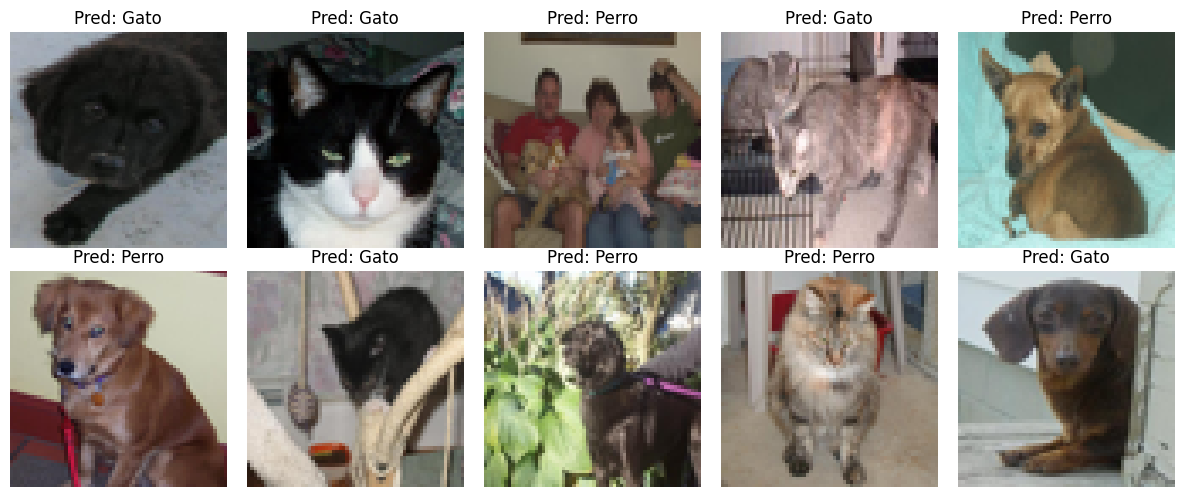

In [8]:
# Mostrar predicciones de ejemplo
classes = ['Gato', 'Perro']
model.eval()  # poner el modelo en modo evaluación

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    img = X_test[i]
    label = y_test[i]
    output = model(img.unsqueeze(0))
    _, pred = torch.max(output, 1)

    ax = axes[i // 5, i % 5]
    ax.imshow(img.permute(1, 2, 0))  # volver a (H, W, C) para mostrar
    ax.set_title(f"Pred: {classes[pred.item()]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [9]:
torch.save(model.state_dict(), 'modelo_cnn.pt')
